In [1]:
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
import numpy as np
import re

In [2]:
def handle_arabic(input_string):
    reshaped_text = arabic_reshaper.reshape(input_string)
    return get_display(reshaped_text)


In [3]:
BART_results_Masc = pd.read_csv("../../English_LMs/encoder_decoder/BART/UK_SOS_Male_BART.csv")
BART_results_Femm = pd.read_csv("../../English_LMs/encoder_decoder/BART/UK_SOS_Female_BART.csv")
BART_results_NB = pd.read_csv("../../English_LMs/encoder_decoder/BART/UK_SOS_Non_Binary_BART.csv")

AlBERT_results_Masc = pd.read_csv("../../English_LMs/Encoder_only/ALBERT/UK_SOS_Male_albert-base-v2.csv")
AlBERT_results_Femm = pd.read_csv("../../English_LMs/Encoder_only/ALBERT/UK_SOS_Female_albert-base-v2.csv")
AlBERT_results_NB = pd.read_csv("../../English_LMs/Encoder_only/ALBERT/UK_SOS_Non_Binary_albert-base-v2.csv")

BERT_results_Masc = pd.read_csv("../../English_LMs/Encoder_only/BERT/UK_SOS_male_bert-base.csv")
BERT_results_Femm = pd.read_csv("../../English_LMs/Encoder_only/BERT/UK_SOS_female_bert-base.csv")
BERT_results_NB = pd.read_csv("../../English_LMs/Encoder_only/BERT/UK_SOS_Non_Binary_bert-base.csv")

XML_Roberta_results_Masc = pd.read_csv("../../English_LMs/Multilingual_LMs/Encoder_only/XLM_Roberta/UK_SOS_Male.csv")
XML_Roberta_results_Femm = pd.read_csv("../../English_LMs/Multilingual_LMs/Encoder_only/XLM_Roberta/UK_SOS_Female.csv")
XML_Roberta_results_NB = pd.read_csv("../../English_LMs/Multilingual_LMs/Encoder_only/XLM_Roberta/UK_SOS_Non_Binary.csv")

In [4]:
def print_SOS_bias_agaonst_specific_identity(toxic_or_not, df, identity):
        identity_df = df[df["identity"] == identity]
        #print("No. entries for "+ identity, len(identity_df))
        group = identity_df["bias_type"].values.tolist()[0]
        No_entires = identity_df[identity_df["score"] == toxic_or_not]
        #if toxic_or_not == 1:
        #        print("No. toxic entries for "+identity,len(No_entires))
        #else:
         #       print("No. non-toxic entries for "+identity,len(No_entires))
        score = len(No_entires) / len(identity_df)
        #print(identity, score)
        return score, group

In [5]:
def assemble_data_in_df (df, identities):
    prcnt_toxic_sent_aginst_identity = []
    prcnt_non_toxic_sent_aginst_identity = []
    groups = []
    #Arabic_Englsih_identities_dict = {Arabic_Englsih_identities.Arabic_identity.values.tolist()[i]: Arabic_Englsih_identities.English_identity.values.tolist()[i] for i in range(len(Arabic_Englsih_identities))}
    for i in identities:
        toxic_score, group_toxic = print_SOS_bias_agaonst_specific_identity(1, df, i)
        non_toxic_score, _ = print_SOS_bias_agaonst_specific_identity(0, df, i)
        
        prcnt_toxic_sent_aginst_identity.append(toxic_score)
        groups.append(group_toxic)
        prcnt_non_toxic_sent_aginst_identity.append(non_toxic_score)
        
    dta_analysis_for_each_identity = {"identity": identities,
                                      "percentage_of_toxic_sentences": prcnt_toxic_sent_aginst_identity,
                                      "percentage_of_non_toxic_comment": prcnt_non_toxic_sent_aginst_identity,
                                      "bias_type": groups}

    dta_analysis_for_each_identity_df = pd.DataFrame(dta_analysis_for_each_identity)
    #dta_analysis_for_each_identity_df["identity_in_english"] = dta_analysis_for_each_identity_df.identity.map(Arabic_Englsih_identities_dict)
    return dta_analysis_for_each_identity_df

In [6]:
def display_identity_SOS_scores(model_data_masc, model_data_femm, model_data_NB):
    model_data_identities_masc = model_data_masc["identity"].unique().tolist()
    data_analysis_for_each_identity_masc = assemble_data_in_df (model_data_masc, model_data_identities_masc)
    data_analysis_for_each_identity_masc = data_analysis_for_each_identity_masc[~data_analysis_for_each_identity_masc["bias_type"].isin(["Social-Class_Marginalized", "Social-Class_Non_Marginalized"])]
    data_analysis_for_each_identity_masc["group"] = ["Marginalized" if i in ["Race_Marginalized","Religion_Marginalized", "Physical_ability_Marginalized", "Gender_Marginalized","Sexual_orientation_Marginalized"] else "Dominant" for i in data_analysis_for_each_identity_masc.bias_type]    
    
    model_data_identities_femm = model_data_femm["identity"].unique().tolist()
    data_analysis_for_each_identity_femm = assemble_data_in_df (model_data_femm, model_data_identities_femm)
    data_analysis_for_each_identity_femm = data_analysis_for_each_identity_femm[~data_analysis_for_each_identity_femm["bias_type"].isin(["Social-Class_Marginalized", "Social-Class_Non_Marginalized"])]
    data_analysis_for_each_identity_femm["group"] = ["Marginalized" if i in ["Race_Marginalized","Religion_Marginalized", "Physical_ability_Marginalized", "Gender_Marginalized","Sexual_orientation_Marginalized"] else "Dominant" for i in data_analysis_for_each_identity_femm.bias_type]
    
    mode_data_identities_NB = model_data_NB["identity"].unique().tolist()
    data_analysis_for_each_identity_NB = assemble_data_in_df (model_data_NB, mode_data_identities_NB)
    data_analysis_for_each_identity_NB = data_analysis_for_each_identity_NB[~data_analysis_for_each_identity_NB["bias_type"].isin(["Social-Class_Marginalized", "Social-Class_Non_Marginalized"])]
    data_analysis_for_each_identity_NB["group"] = ["Marginalized" if i in ["Race_Marginalized","Religion_Marginalized", "Physical_ability_Marginalized", "Gender_Marginalized","Sexual_orientation_Marginalized"] else "Dominant" for i in data_analysis_for_each_identity_NB.bias_type]
    
    data_analysis_for_each_identity_masc["gender"] = ["Masc" for i in range(0,len(data_analysis_for_each_identity_masc))]
    data_analysis_for_each_identity_femm["gender"] = ["Femm" for i in range(0,len(data_analysis_for_each_identity_femm))]
    data_analysis_for_each_identity_NB["gender"] = ["Non-Binary" for i in range(0,len(data_analysis_for_each_identity_NB))]
    
    data_analysis = pd.concat([data_analysis_for_each_identity_masc, data_analysis_for_each_identity_femm,
                               data_analysis_for_each_identity_NB])
    
    return data_analysis

In [7]:
def match_sens_attr (x):
    att = " "
    if x in ["Sexual_orientation_Marginalized"]:
        att = "sexual orientation (M)"
    if x in [ "Sexual_orientation_Non_Marginalized"]:
        att = "sexual orientation (N)"
        
    elif x in ["Religion_Marginalized"]:
        att = "religion (M)"
    elif x in ["Religion_Non_Marginalized"]:
        att = "religion (N)"
        
    elif x in ["Race_Marginalized"]:
        att = "race (M)"
    elif x in ["Race_Non_marginalized"]:
        att = "race (N)"
        
    elif x in ["Physical_ability_Marginalized"]:
        att = "disability (M)"
    elif x in ["Physical_ability_Non_Marginalized"]:
        att = "disability (N)"
        
    elif x in ["Refugees_Marginalized"]:
        att = "refugees (M)"
    elif x in ["Refugees_Non_Marginalized"]:
        att = "refugees (N)"
        
    elif x in ["Gender_Marginalized"]:
        att = "gender (M)"
    elif x in ["Gender_Non_marginalized"]:
        att = "gender (N)"
        
    return att


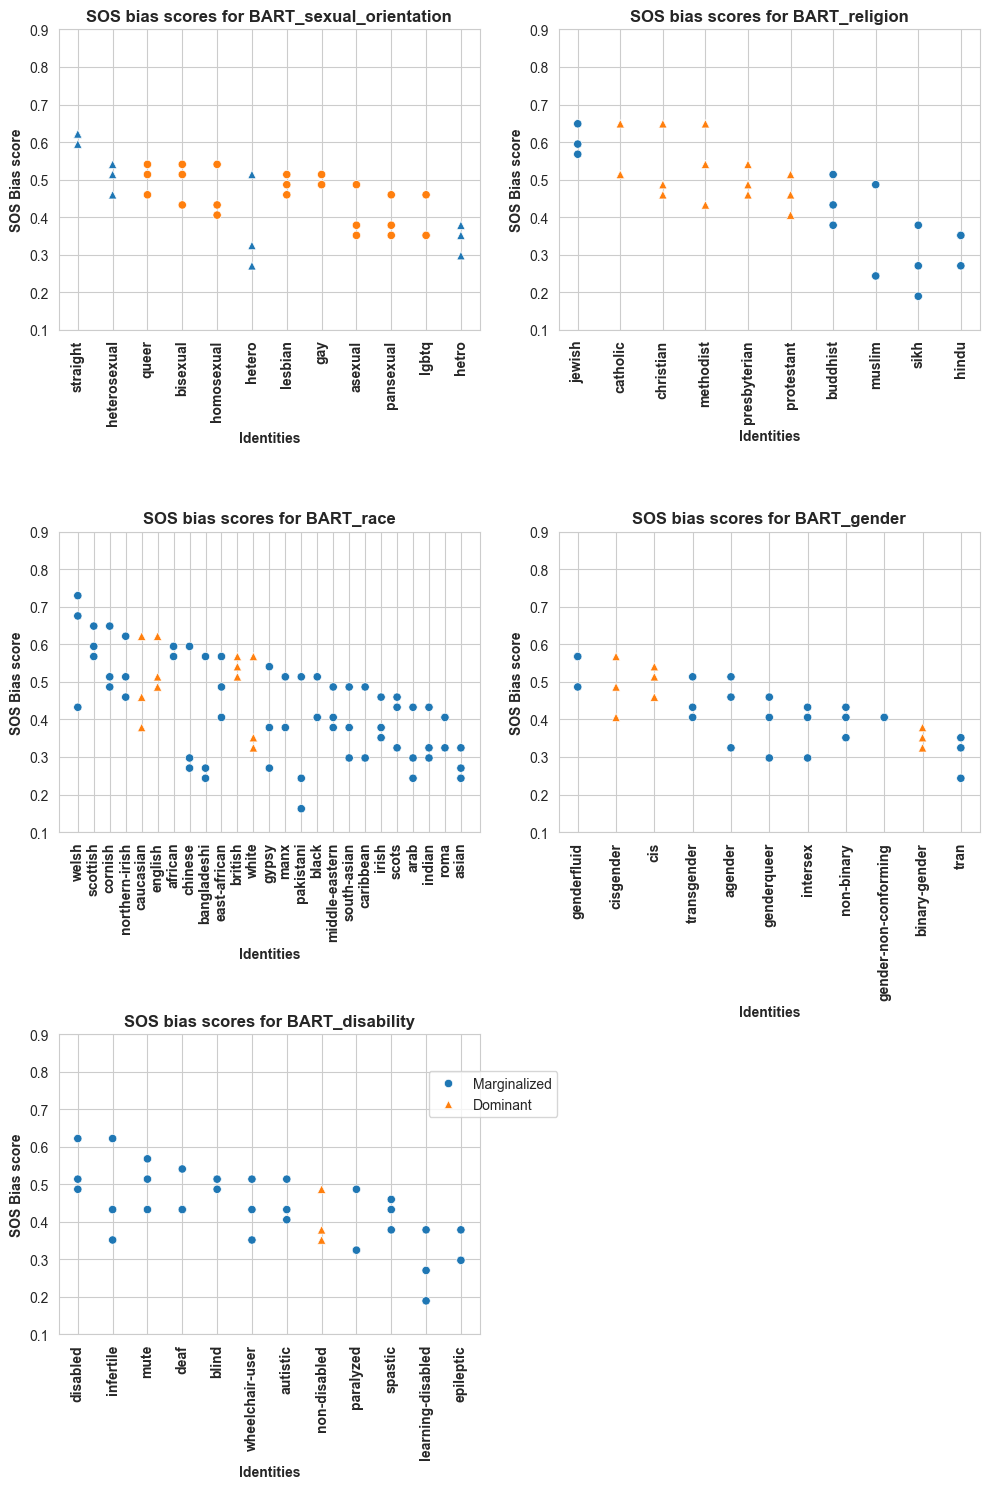

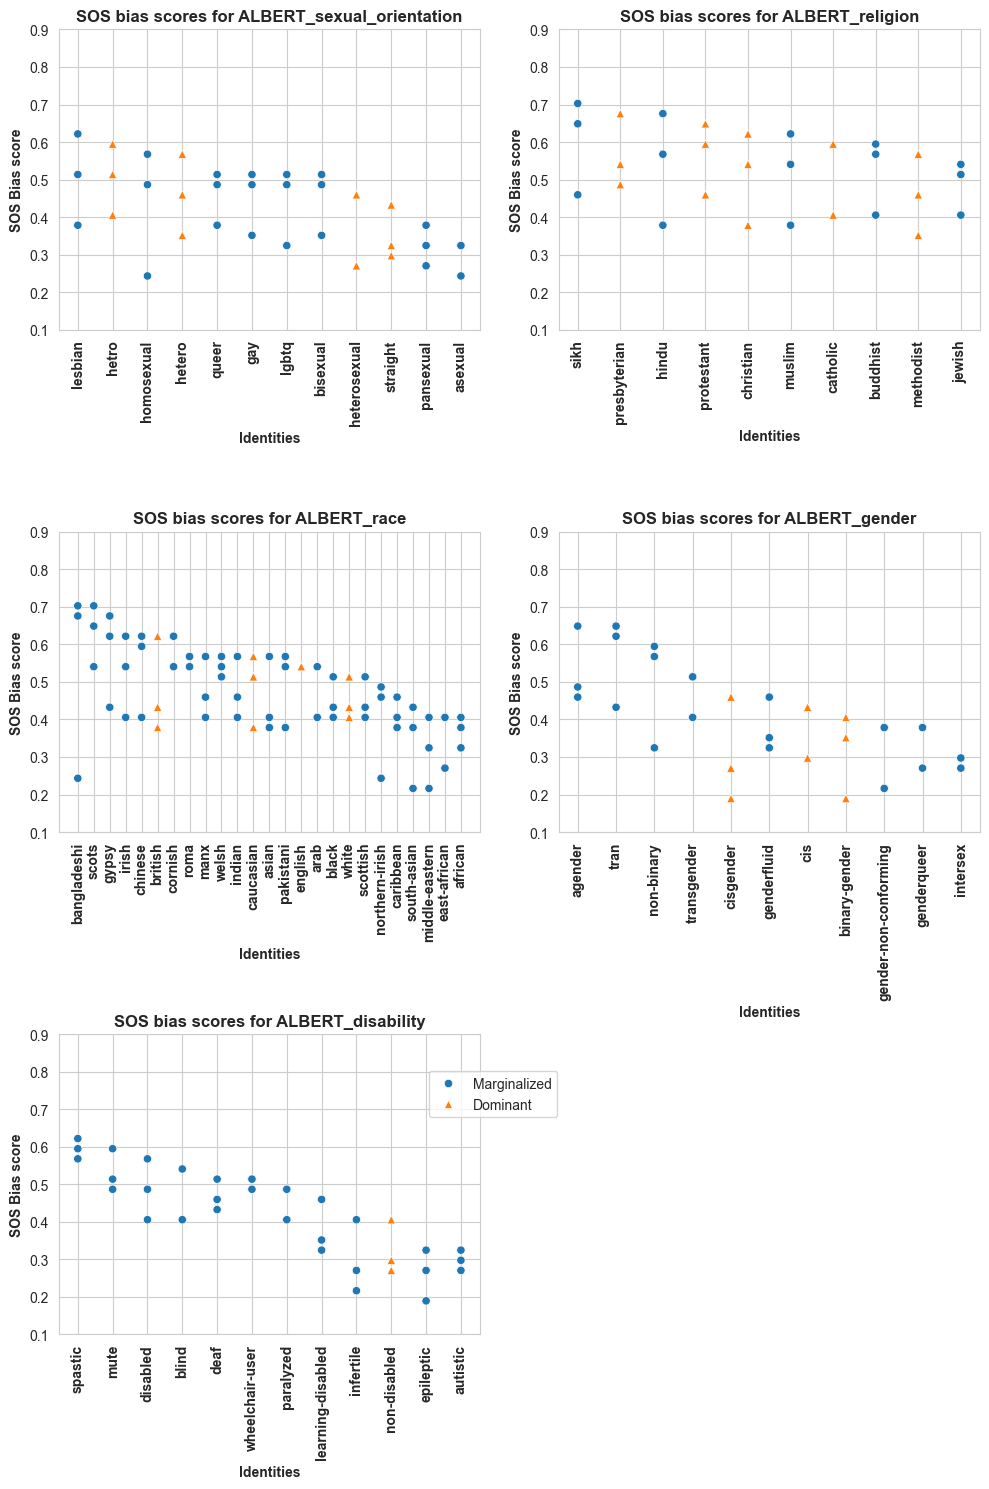

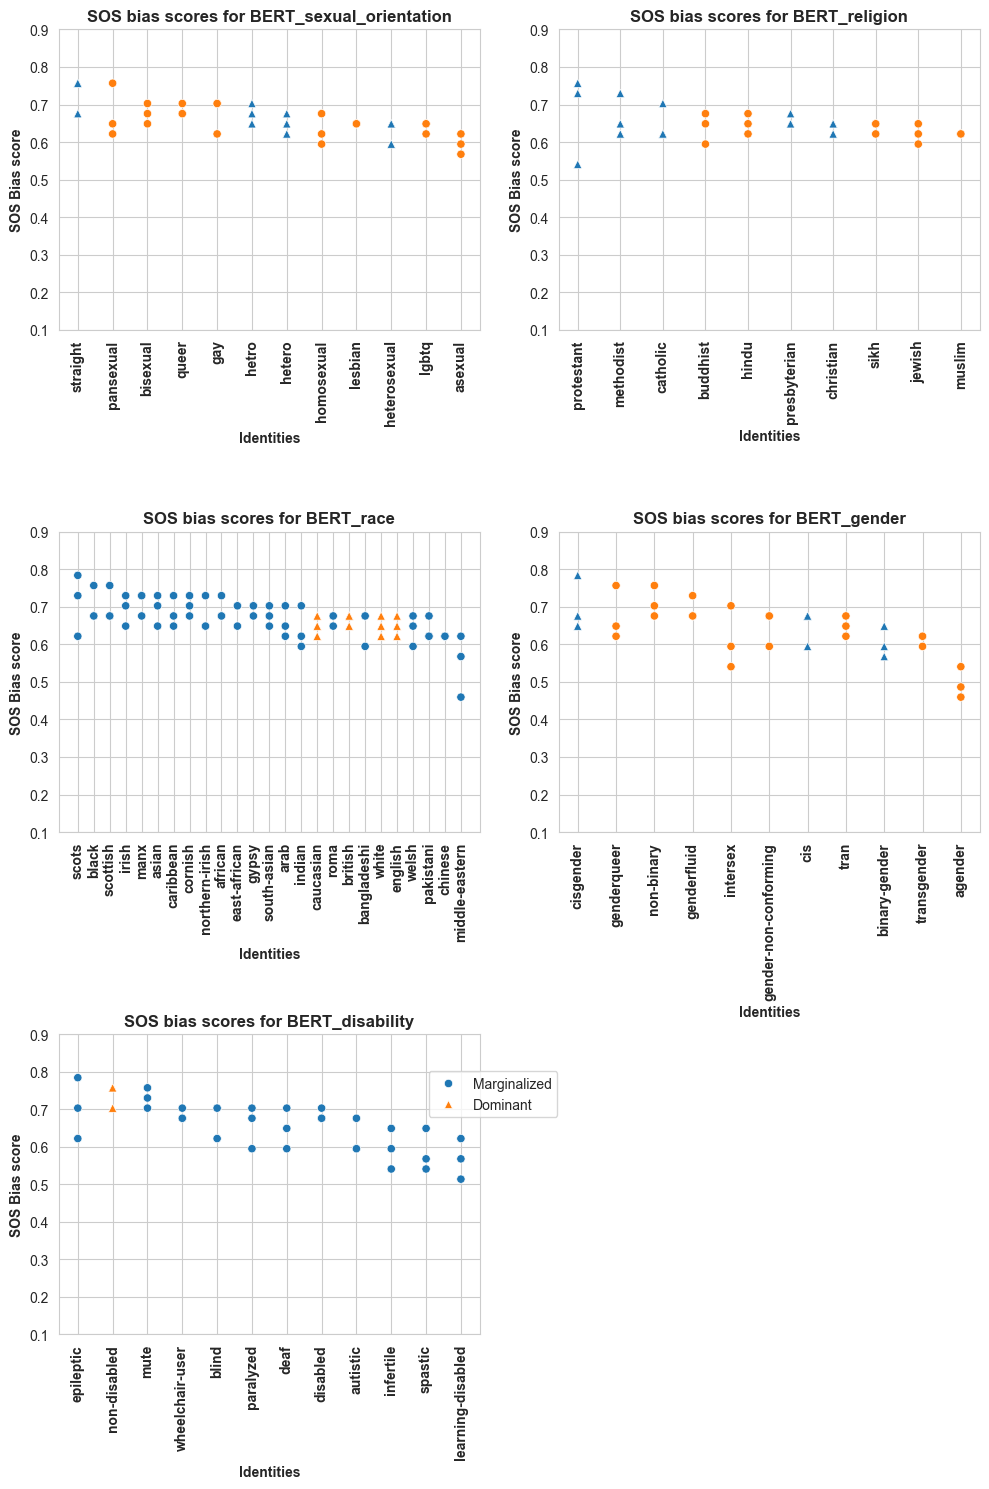

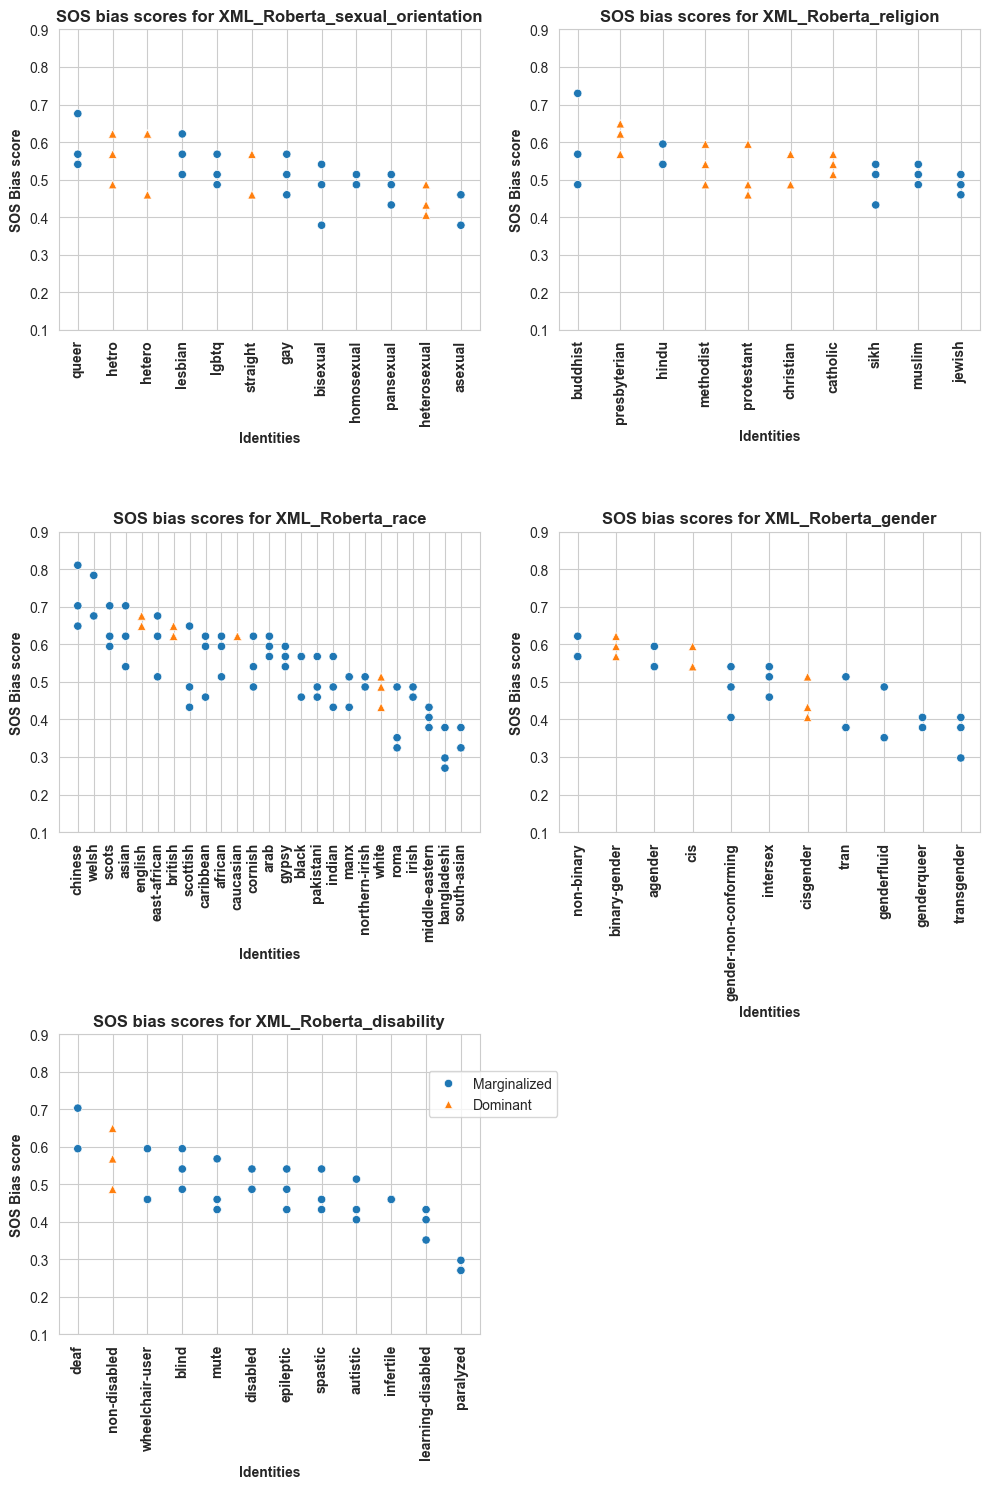

In [8]:
def plot_sos_bias_for_each_senstive_attribute(model_results_Masc, model_results_Femm, model_results_NB, model_name):
    fig, axs = plt.subplots(3,2, figsize=(10,15))
    palette = {"Dominant":"tomato", "Marginalized":"purple"}
    #fig.suptitle("SOS AraAlBERT Bias scores (Arabic and multilingual AraAlBERT Egypt and Egyptian Arabic)", fontweight="bold")
    
    model = display_identity_SOS_scores(model_results_Masc, model_results_Femm, model_results_NB)
    
    model_sexual_orientation = model[model["bias_type"].isin(["Sexual_orientation_Marginalized","Sexual_orientation_Non_Marginalized"])]
    model_sexual_orientation = model_sexual_orientation.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih1 = []
    for i, r in model_sexual_orientation.groupby("identity", sort=False, as_index=False):
        identityies_in_englsih1.append(r["identity"].values[0])
    
    sns.scatterplot(data = model_sexual_orientation, x='identity', y='percentage_of_toxic_sentences', style="group", hue="group", ax=axs[0,0], markers={'Dominant':"^", 'Marginalized':"o"})
    axs[0,0].set_xticks(range(0, len(identityies_in_englsih1)),identityies_in_englsih1, rotation = 90, fontweight='bold')
    axs[0,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[0,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[0,0].set_xlabel("Identities", fontweight="bold")
    axs[0,0].set_yticks(np.arange(0.1,1,0.1))
    axs[0,0].get_legend().remove()
    axs[0,0].set_title("SOS bias scores for "+model_name+"_sexual_orientation", fontweight='bold')
    #fig1.savefig('SOS bias scores for AraAlBERT_sexual_orientation (Egypt).png', bbox_inches='tight')
    
    model_religion = model[model["bias_type"].isin(["Religion_Marginalized",
                                                           "Religion_Non_Marginalized"])]
    model_religion = model_religion.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih2 = []
    for i, r in model_religion.groupby("identity", sort=False, as_index=False):
        identityies_in_englsih2.append(r["identity"].values[0])
    
    
    sns.scatterplot(data = model_religion, x='identity', y='percentage_of_toxic_sentences', hue="group", style="group", ax=axs[0,1], markers={'Dominant':"^", 'Marginalized':"o"})
    axs[0,1].set_xticks(range(0, len(identityies_in_englsih2)),identityies_in_englsih2, rotation = 90, fontweight='bold')
    axs[0,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[0,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[0,1].set_xlabel("Identities", fontweight="bold")
    axs[0,1].set_yticks(np.arange(0.1,1,0.1))
    axs[0,1].get_legend().remove()
    axs[0,1].set_title("SOS bias scores for "+model_name+"_religion", fontweight='bold')
    #fig2.savefig('SOS bias scores for AraAlBERT_religion (Egypt).png', bbox_inches='tight')
    
    model_race = model[model["bias_type"].isin(["Race_Marginalized",
                                                           "Race_Non_marginalized"])]
    model_race = model_race.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih3 = []
    for i, r in model_race.groupby("identity", sort=False, as_index=False):
        identityies_in_englsih3.append(r["identity"].values[0])
    
    
    sns.scatterplot(data = model_race, x='identity', y='percentage_of_toxic_sentences', style="group", hue="group", ax=axs[1,0], markers={'Dominant':"^", 'Marginalized':"o"})
    axs[1,0].set_xticks(range(0, len(identityies_in_englsih3)),identityies_in_englsih3, rotation = 90, fontweight='bold')
    axs[1,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[1,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[1,0].set_xlabel("Identities", fontweight="bold")
    axs[1,0].set_yticks(np.arange(0.1,1,0.1))
    axs[1,0].get_legend().remove()
    axs[1,0].set_title("SOS bias scores for "+model_name+"_race", fontweight='bold')
    #fig3.savefig('SOS bias scores for AraAlBERT_race (Egypt).png', bbox_inches='tight')
    
    
    model_gender = model[model["bias_type"].isin(["Gender_Marginalized",
                                                           "Gender_Non_marginalized"])]
    model_gender = model_gender.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih4 = []
    for i, r in model_gender.groupby("identity", sort=False, as_index=False):
        identityies_in_englsih4.append(r["identity"].values[0])
    
    
    sns.scatterplot(data = model_gender, x='identity', y='percentage_of_toxic_sentences', style="group",hue="group",  ax=axs[1,1], markers={'Dominant':"^", 'Marginalized':"o"})
    axs[1,1].set_xticks(range(0, len(identityies_in_englsih4)),identityies_in_englsih4, rotation = 90, fontweight='bold')
    axs[1,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[1,1].set_ylabel("SOS Bias score", fontweight="bold")
    axs[1,1].set_xlabel("Identities", fontweight="bold")
    axs[1,1].set_yticks(np.arange(0.1,1,0.1))
    axs[1,1].get_legend().remove()
    axs[1,1].set_title("SOS bias scores for "+model_name+"_gender", fontweight='bold')
    #fig4.savefig('SOS bias scores for AraAlBERT_gender (Egypt).png', bbox_inches='tight')
    
    model_disability = model[model["bias_type"].isin(["Physical_ability_Marginalized",
                                                           "Physical_ability_Non_Marginalized"])]
    
    model_disability = model_disability.sort_values(by="percentage_of_toxic_sentences", ascending=False)
    
    identityies_in_englsih5 = []
    for i, r in model_disability.groupby("identity", sort=False, as_index=False):
        identityies_in_englsih5.append(r["identity"].values[0])


    sns.scatterplot(data = model_disability, x='identity', y='percentage_of_toxic_sentences',hue="group", style="group", ax=axs[2,0],  markers={'Dominant':"^", 'Marginalized':"o"})
    axs[2,0].set_xticks(range(0, len(identityies_in_englsih5)),identityies_in_englsih5, rotation = 90, fontweight='bold')
    axs[2,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
    axs[2,0].set_ylabel("SOS Bias score", fontweight="bold")
    axs[2,0].set_xlabel("Identities", fontweight="bold")
    axs[2,0].set_yticks(np.arange(0.1,1,0.1))
    #axs[2,0].get_legend().remove()
    axs[2,0].set_title("SOS bias scores for "+model_name+"_disability", fontweight='bold')
    #fig5.savefig('SOS bias scores for AraAlBERT_disability (Egypt).png', bbox_inches='tight')
    
    axs[-1, -1].axis('off')
    fig.tight_layout()
    fig.savefig('SOS bias scores for '+model_name+ '(UK).png', bbox_inches='tight')
    
    
plot_sos_bias_for_each_senstive_attribute(BART_results_Masc, BART_results_Femm, BART_results_NB, "BART")
plot_sos_bias_for_each_senstive_attribute(AlBERT_results_Masc, AlBERT_results_Femm, AlBERT_results_NB, "ALBERT")
plot_sos_bias_for_each_senstive_attribute(BERT_results_Masc, BERT_results_Femm, BERT_results_NB, "BERT")
plot_sos_bias_for_each_senstive_attribute(XML_Roberta_results_Masc, XML_Roberta_results_Femm, XML_Roberta_results_NB, "XML_Roberta")


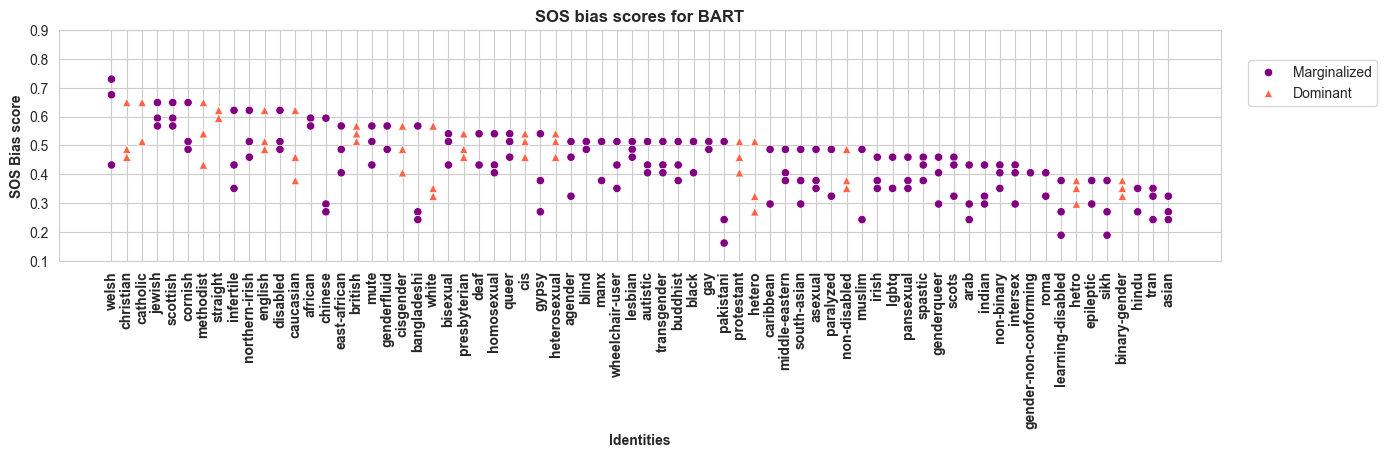

In [10]:
BART = display_identity_SOS_scores(BART_results_Masc, BART_results_Femm, BART_results_NB)
BART = BART.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in BART.groupby("identity", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}
fig1, axs1 = plt.subplots(figsize=(15, 3))
sns.scatterplot(data = BART, x='identity', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs1, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs1.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs1.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs1.set_ylabel("SOS Bias score", fontweight="bold")
axs1.set_xlabel("Identities", fontweight="bold")
axs1.set_yticks(np.arange(0.1,1,0.1))
axs1.set_title("SOS bias scores for BART", fontweight='bold')
fig1.savefig('SOS bias scores for BART.png', bbox_inches='tight')

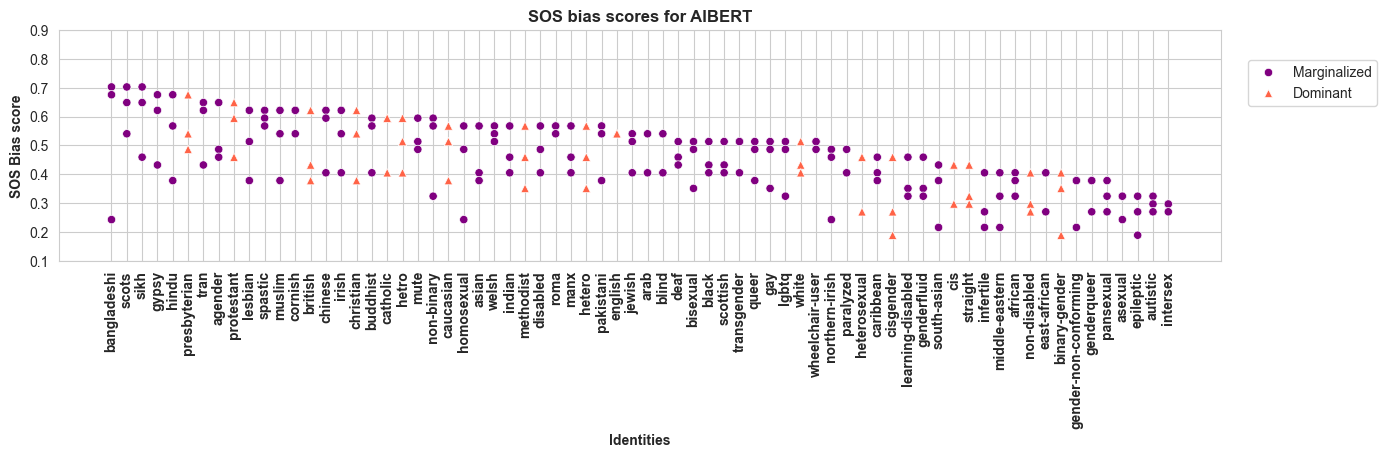

In [11]:
AlBERT = display_identity_SOS_scores(AlBERT_results_Masc, AlBERT_results_Femm, AlBERT_results_NB)
AlBERT = AlBERT.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in AlBERT.groupby("identity", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity"].values[0])
    
palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig2, axs2 = plt.subplots(figsize=(15, 3))
sns.scatterplot(data = AlBERT, x='identity', y='percentage_of_toxic_sentences', style="group", hue='group', ax=axs2, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs2.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs2.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs2.set_ylabel("SOS Bias score", fontweight="bold")
axs2.set_xlabel("Identities", fontweight="bold")
axs2.set_yticks(np.arange(0.1,1,0.1))
axs2.set_title("SOS bias scores for AlBERT", fontweight='bold')
fig2.savefig('SOS bias scores for AlBERT.png', bbox_inches='tight')

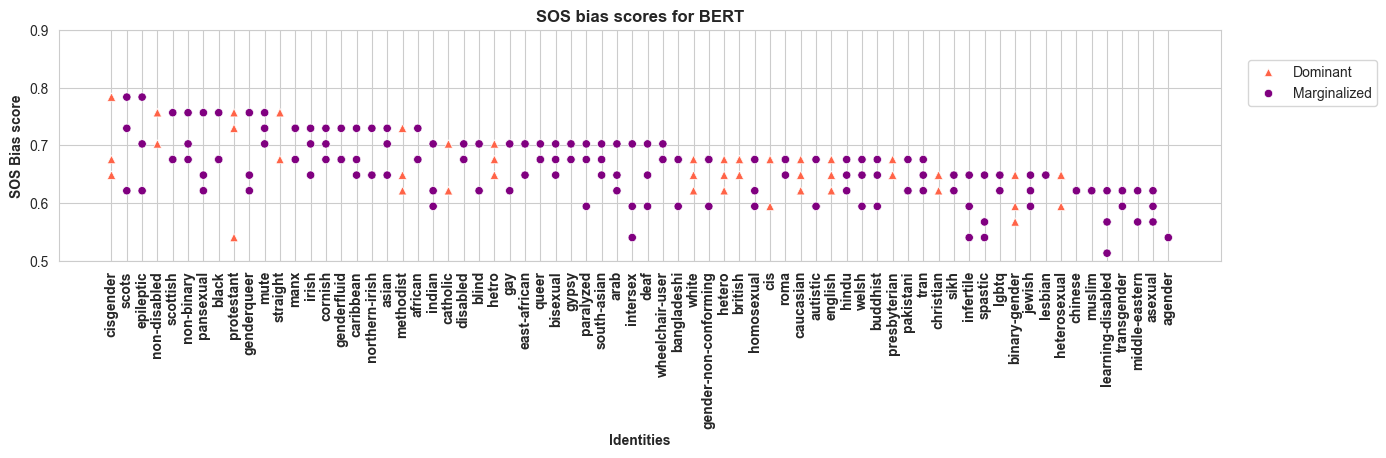

In [12]:
BERT = display_identity_SOS_scores(BERT_results_Masc, BERT_results_Femm, BERT_results_NB)
BERT = BERT[BERT["percentage_of_toxic_sentences"] >0.5].sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in BERT[BERT["percentage_of_toxic_sentences"] >0.5].groupby("identity", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig3, axs3 = plt.subplots(figsize=(15, 3))
sns.scatterplot(data = BERT[BERT["percentage_of_toxic_sentences"] >0.5], x='identity', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs3, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs3.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs3.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs3.set_ylabel("SOS Bias score", fontweight="bold")
axs3.set_xlabel("Identities", fontweight="bold")
axs3.set_yticks(np.arange(0.5,1,0.1))
axs3.set_title("SOS bias scores for BERT", fontweight='bold')
fig3.savefig('SOS bias scores for BERT bias scores more than 0_5.png', bbox_inches='tight')

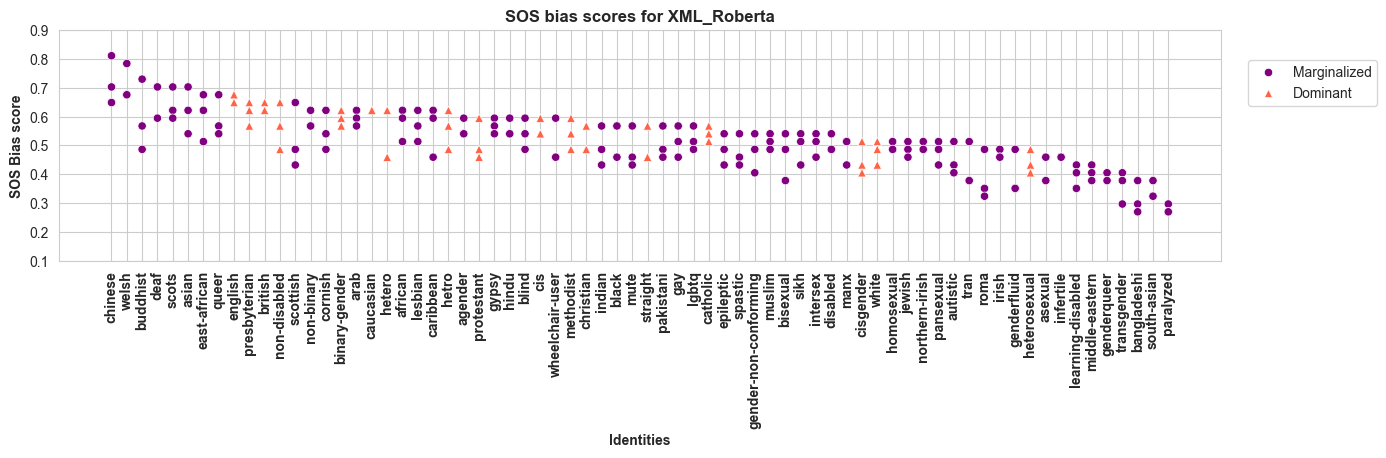

In [13]:
XML_Roberta = display_identity_SOS_scores(XML_Roberta_results_Masc, XML_Roberta_results_Femm, XML_Roberta_results_NB)
XML_Roberta = XML_Roberta.sort_values(by="percentage_of_toxic_sentences", ascending=False)

identityies_in_englsih = []
for i, r in XML_Roberta.groupby("identity", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig4, axs4 = plt.subplots(figsize=(15, 3))
sns.scatterplot(data = XML_Roberta, x='identity', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs4, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs4.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs4.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs4.set_ylabel("SOS Bias score", fontweight="bold")
axs4.set_xlabel("Identities", fontweight="bold")
axs4.set_yticks(np.arange(0.1,1,0.1))
axs4.set_title("SOS bias scores for XML_Roberta", fontweight='bold')
fig4.savefig('SOS bias scores for XML_Roberta.png', bbox_inches='tight')

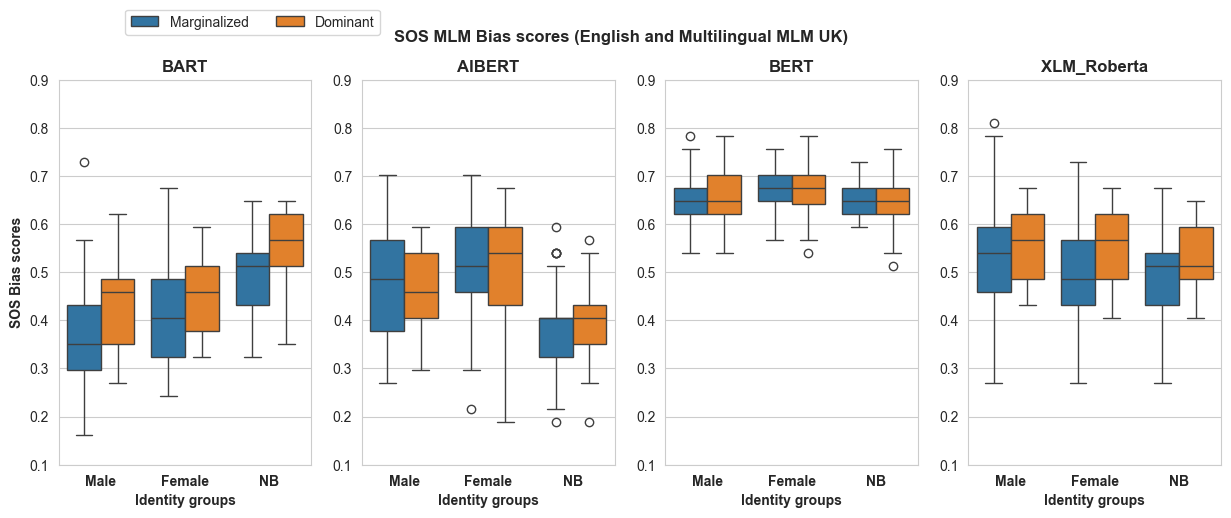

In [14]:
fig, axs = plt.subplots(1,4, figsize=(15, 5))
fig.suptitle("SOS MLM Bias scores (English and Multilingual MLM UK)", fontweight="bold")

sns.boxplot(data=BART, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[0])
axs[0].set_title("BART", fontweight="bold")
axs[0].legend(bbox_to_anchor=(1.1, 0.4, 0.2, 0.8),ncol=3)
#axs[0].set_xticks("")
#axs[0].set(xlabel="")
axs[0].set_ylabel("SOS Bias scores", fontweight="bold")
#axs[0].get_legend().remove()
axs[0].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[0].set_yticks(np.arange(0.1,1,0.1))
axs[0].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=AlBERT, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[1])
axs[1].set_title("AlBERT", fontweight="bold")
#axs[1].legend(bbox_to_anchor=(0.8, 0.7, 0.2, 0.8),ncol=3)
#axs[1].set(xlabel="")
axs[1].set(ylabel="")
#axs[1].set_xticks("")
axs[1].get_legend().remove()
axs[1].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[1].set_yticks(np.arange(0.1,1,0.1))
axs[1].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=BERT, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[2])
axs[2].set_title("BERT", fontweight="bold")
#axs[2].legend(bbox_to_anchor=(0.2, -0.5, 0.2, 0.8),ncol=3)
axs[2].get_legend().remove()
axs[2].set(ylabel="")
axs[2].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[2].set_yticks(np.arange(0.1,1,0.1))
axs[2].set_xlabel("Identity groups", fontweight="bold")

sns.boxplot(data=XML_Roberta, y="percentage_of_toxic_sentences", x="gender", hue="group",ax=axs[3])
axs[3].set_title("XLM_Roberta", fontweight="bold")
#axs[3].legend(bbox_to_anchor=(0.8, -1.1, 0.1, 0.8),ncol=3)
axs[3].set(ylabel="")
axs[3].get_legend().remove()
axs[3].set_xticks([0,1,2], ["Male", "Female", "NB"], fontweight="bold")
axs[3].set_yticks(np.arange(0.1,1,0.1))
axs[3].set_xlabel("Identity groups", fontweight="bold")


fig.savefig('Summarized_SOS_bias_scores_UK_boxplot.png', bbox_inches='tight')

In [15]:
print("BART", BART.percentage_of_toxic_sentences.mean())
print("BERT", BERT.percentage_of_toxic_sentences.mean())
print("AlBERT", AlBERT.percentage_of_toxic_sentences.mean())
print("XML_Roberta", XML_Roberta.percentage_of_toxic_sentences.mean())


BART 0.44079794079794077
BERT 0.6601383992688343
AlBERT 0.4532818532818533
XML_Roberta 0.5160875160875161


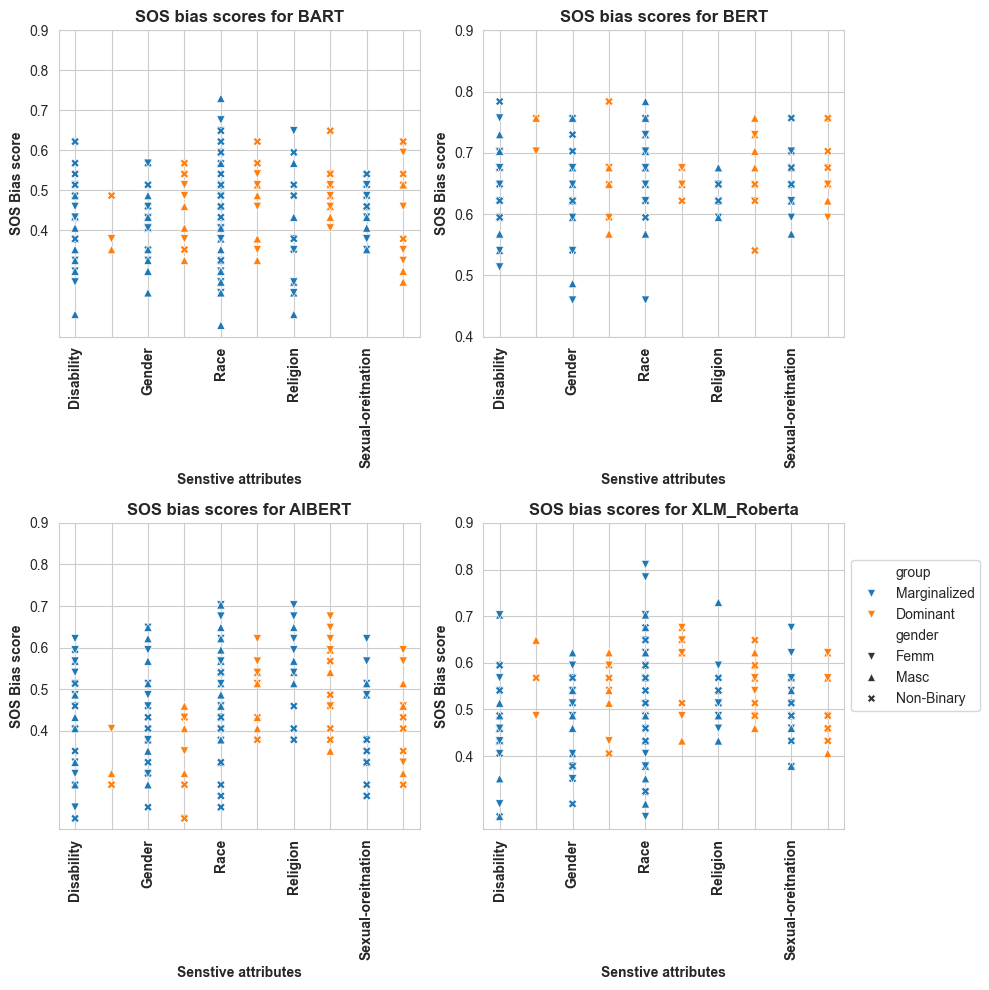

In [15]:
fig, axs = plt.subplots(2,2, figsize=(10,10))

xlabels = ["Disability","", "Gender", '', "Race", "", "Religion","", "Sexual-oreitnation",""]

BART_display = display_identity_SOS_scores(BART_results_Masc, BART_results_Femm, BART_results_NB)
BART_display["sens_attribute"] = BART_display["bias_type"].apply(lambda x:match_sens_attr(x))
BART_display["Model_Name"] = "BART"
BART_display = BART_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = BART_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[0,0],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[0,0].set_xticks(range(0, len(BART_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[0,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[0,0].set_ylabel("SOS Bias score", fontweight="bold")
axs[0,0].set_xlabel("Senstive attributes", fontweight="bold")
axs[0,0].set_yticks(np.arange(0.4,1,0.1))
axs[0,0].set_title("SOS bias scores for BART", fontweight='bold')
axs[0,0].get_legend().remove()
axs[0,0].set_title("SOS bias scores for BART", fontweight='bold')
    

BERT_display = display_identity_SOS_scores(BERT_results_Masc, BERT_results_Femm, BERT_results_NB)
BERT_display["sens_attribute"] = BERT_display["bias_type"].apply(lambda x:match_sens_attr(x))
BERT_display["Model_Name"] = "BERT"
BERT_display = BERT_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = BERT_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[0,1],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[0,1].set_xticks(range(0, len(BERT_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[0,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[0,1].set_ylabel("SOS Bias score", fontweight="bold")
axs[0,1].set_xlabel("Senstive attributes", fontweight="bold")
axs[0,1].set_yticks(np.arange(0.4,1,0.1))
axs[0,1].set_title("SOS bias scores for BERT", fontweight='bold')
axs[0,1].get_legend().remove()
axs[0,1].set_title("SOS bias scores for BERT", fontweight='bold')


AlBERT_display = display_identity_SOS_scores(AlBERT_results_Masc, AlBERT_results_Femm, AlBERT_results_NB)
AlBERT_display["sens_attribute"] = AlBERT_display["bias_type"].apply(lambda x:match_sens_attr(x))
AlBERT_display["Model_Name"] = "AlBERT"
AlBERT_display = AlBERT_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = AlBERT_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[1,0],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[1,0].set_xticks(range(0, len(AlBERT_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[1,0].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[1,0].set_ylabel("SOS Bias score", fontweight="bold")
axs[1,0].set_xlabel("Senstive attributes", fontweight="bold")
axs[1,0].set_yticks(np.arange(0.4,1,0.1))
axs[1,0].set_title("SOS bias scores for AlBERT", fontweight='bold')
axs[1,0].get_legend().remove()
axs[1,0].set_title("SOS bias scores for AlBERT", fontweight='bold')

XML_Roberta_display = display_identity_SOS_scores(XML_Roberta_results_Masc, XML_Roberta_results_Femm, XML_Roberta_results_NB)
XML_Roberta_display["sens_attribute"] = XML_Roberta_display["bias_type"].apply(lambda x:match_sens_attr(x))
XML_Roberta_display["Model_Name"] = "XLM_RoBERTa"
XML_Roberta_display = XML_Roberta_display.sort_values(by=["sens_attribute"], ascending=[True])
sns.scatterplot(data = XML_Roberta_display, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', style="gender", ax=axs[1,1],  markers={'Masc':'^', 'Femm':"v", 'Non-Binary':'X'})
axs[1,1].set_xticks(range(0, len(XML_Roberta_display["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs[1,1].legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs[1,1].set_ylabel("SOS Bias score", fontweight="bold")
axs[1,1].set_xlabel("Senstive attributes", fontweight="bold")
axs[1,1].set_yticks(np.arange(0.4,1,0.1))
axs[1,1].set_title("SOS bias scores for XLM_Roberta", fontweight='bold')
#axs[2,1].get_legend().remove()
axs[1,1].set_title("SOS bias scores for XLM_Roberta", fontweight='bold')  

    
fig.tight_layout()
fig.savefig('SOS bias scores for distribution of senstive attribues in different models in UK.png', bbox_inches='tight')


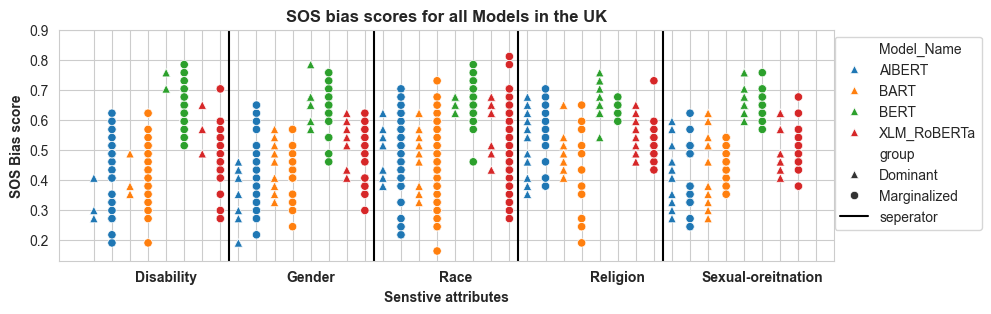

In [26]:
All_model_dispplays = pd.concat([BART_display, BERT_display, AlBERT_display, XML_Roberta_display])

def sens_attribute_name(x):
    att= ""
    if x in ["Sexual_orientation_Marginalized","Sexual_orientation_Non_Marginalized"]:
            att = "sexual orientation"
        
    elif x in ["Religion_Marginalized", "Religion_Non_Marginalized"]:
            att = "religion"
        
    elif x in ["Race_Marginalized","Race_Non_marginalized"]:
            att = "race"
            
    elif x in ["Physical_ability_Marginalized","Physical_ability_Non_Marginalized"]:
            att = "disability"
            
    elif x in ["Refugees_Marginalized","Refugees_Non_Marginalized"]:
            att = "refugees"
            
    elif x in ["Gender_Marginalized","Gender_Non_marginalized"]:
            att = "gender"
    return att

xlabels = ["","","","","Disability","","","",
           "","","","","Gender","","","",
           "","","","","Race","","","","",
           "","","","","Religion","","","",
           "","","","","Sexual-oreitnation","","",""]

All_model_dispplays["sens_attribute2"] = All_model_dispplays.apply(lambda x:sens_attribute_name(x["bias_type"])+"_"+x["Model_Name"]+"_"+x["group"], axis=1)

All_model_dispplays = All_model_dispplays.sort_values(by=["sens_attribute2"], ascending=[True])


fig7, axs7 = plt.subplots(figsize=(10, 3))
sns.scatterplot(data = All_model_dispplays, x='sens_attribute2', hue='Model_Name', y='percentage_of_toxic_sentences', style = 'group', ax=axs7, markers={'Marginalized':"o", 'Dominant':'^'})
plt.axvline(7.5,color='black', label='seperator')
plt.axvline(15.5,color='black')
plt.axvline(23.5,color='black')
plt.axvline(31.5,color='black')

axs7.set_xticks(range(0, len(xlabels)),xlabels, rotation = 0, fontweight='bold')
axs7.legend(bbox_to_anchor=(1, 0.2, 0.2, 0.8),ncol=1)
axs7.set_ylabel("SOS Bias score", fontweight="bold")
axs7.set_xlabel("Senstive attributes", fontweight="bold")
axs7.set_yticks(np.arange(0.2,1,0.1))
axs7.set_title("SOS bias scores for all Models in the UK", fontweight='bold')
#axs7.get_legend().remove()
plt.show()
fig7.savefig('SOS bias scores for all models displays senstive attribues.png', bbox_inches='tight')

## All models

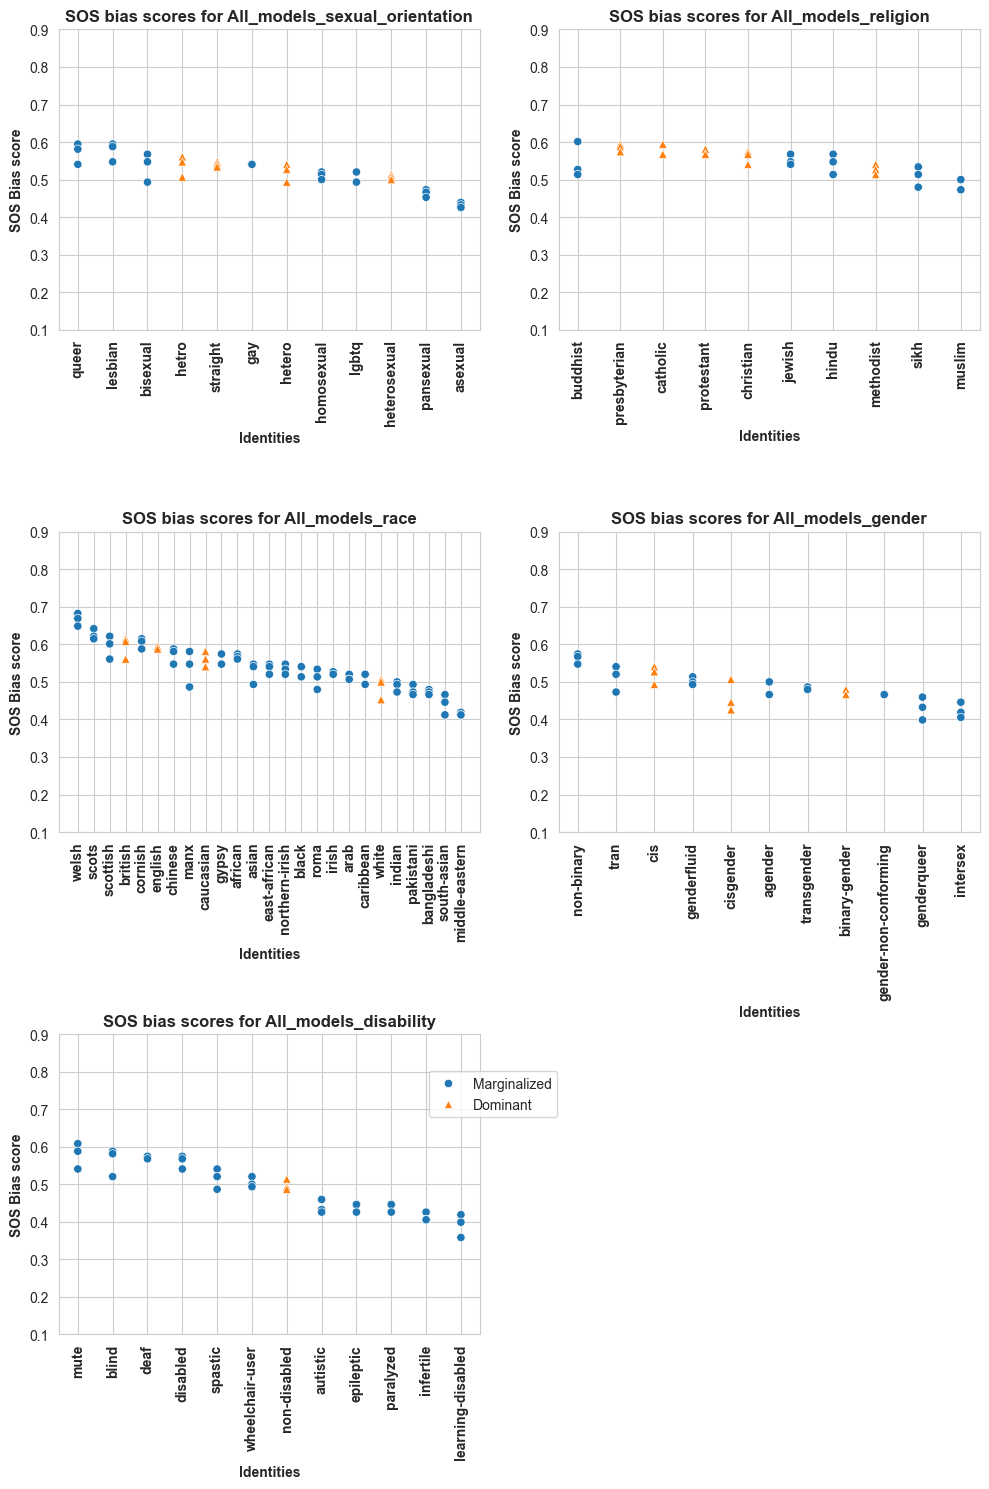

In [16]:
All_models_MASC = pd.concat([BART_results_Masc, BERT_results_Masc, AlBERT_results_Masc, XML_Roberta_results_Masc])

All_models_Femm = pd.concat([BART_results_Femm, BERT_results_Femm, AlBERT_results_Femm, XML_Roberta_results_Femm])

All_models_NB = pd.concat([BART_results_Masc, BERT_results_Femm, AlBERT_results_Femm, XML_Roberta_results_Femm])

plot_sos_bias_for_each_senstive_attribute(All_models_MASC, All_models_Femm, All_models_NB, "All_models")

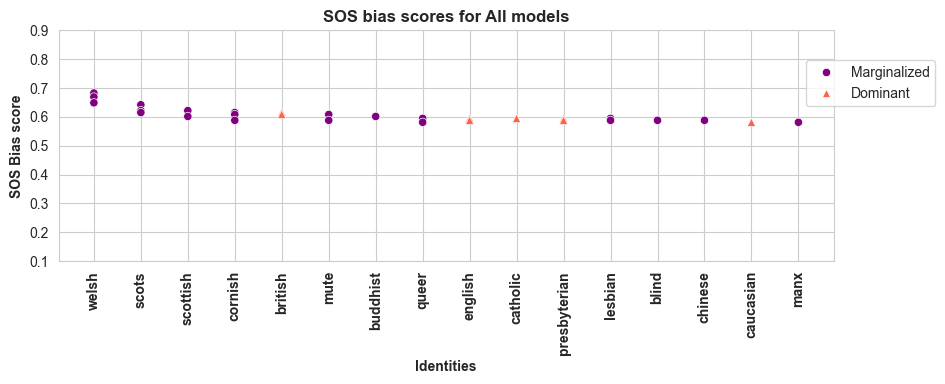

In [17]:
all_models = display_identity_SOS_scores(All_models_MASC, All_models_Femm, All_models_NB)
all_models = all_models.sort_values(by="percentage_of_toxic_sentences", ascending=False)
all_models = all_models.head(30)

identityies_in_englsih = []
for i, r in all_models.groupby("identity", sort=False, as_index=False):
    identityies_in_englsih.append(r["identity"].values[0])

palette = {"Dominant":"tomato", "Marginalized":"purple"}

fig4, axs4 = plt.subplots(figsize=(10, 3))
sns.scatterplot(data = all_models, x='identity', y='percentage_of_toxic_sentences', hue='group', style="group", ax=axs4, palette=palette, markers={'Dominant':"^", 'Marginalized':"o"})
axs4.set_xticks(range(0, len(identityies_in_englsih)),identityies_in_englsih, rotation = 90, fontweight='bold')
axs4.legend(bbox_to_anchor=(0.94, 0.1, 0.2, 0.8),ncol=1)
axs4.set_ylabel("SOS Bias score", fontweight="bold")
axs4.set_xlabel("Identities", fontweight="bold")
axs4.set_yticks(np.arange(0.1,1,0.1))
axs4.set_title("SOS bias scores for All models", fontweight='bold')
fig4.savefig('SOS bias scores for average All models.png', bbox_inches='tight')

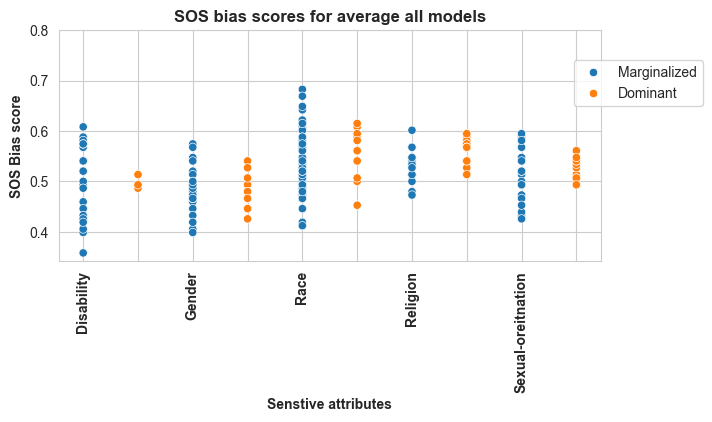

In [22]:
All_Models = display_identity_SOS_scores(All_models_MASC, All_models_Femm, All_models_NB)
xlabels = ["Disability","", "Gender", '', "Race", "", "Religion","", "Sexual-oreitnation",""]

All_Models["sens_attribute"] = All_Models["bias_type"].apply(lambda x:match_sens_attr(x))
All_Models = All_Models.sort_values(by=["sens_attribute"], ascending=[True])


fig7, axs7 = plt.subplots(figsize=(7, 3))
sns.scatterplot(data = All_Models, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', ax=axs7, markers={'Masc':'^', 'Femm':"v", 'Non-Binary':"X"})
axs7.set_xticks(range(0, len(All_Models["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs7.legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs7.set_ylabel("SOS Bias score", fontweight="bold")
axs7.set_xlabel("Senstive attributes", fontweight="bold")
axs7.set_yticks(np.arange(0.4,0.9,0.1))
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
#axs7.get_legend().remove()
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
plt.show()
fig7.savefig('SOS bias scores for average All_Models senstive attribues.png', bbox_inches='tight')

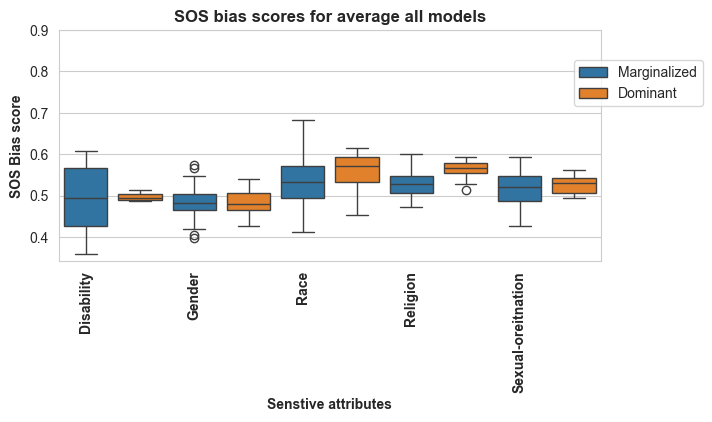

In [21]:
All_Models = display_identity_SOS_scores(All_models_MASC, All_models_Femm, All_models_NB)
xlabels = ["Disability","", "Gender", '', "Race", "", "Religion","", "Sexual-oreitnation",""]

All_Models["sens_attribute"] = All_Models["bias_type"].apply(lambda x:match_sens_attr(x))
All_Models = All_Models.sort_values(by=["sens_attribute"], ascending=[True])


fig7, axs7 = plt.subplots(figsize=(7, 3))
sns.boxplot(data = All_Models, x='sens_attribute', hue='group', y='percentage_of_toxic_sentences', ax=axs7)
axs7.set_xticks(range(0, len(All_Models["sens_attribute"].unique())),xlabels, rotation = 90, fontweight='bold')
axs7.legend(bbox_to_anchor=(1, 0.1, 0.2, 0.8),ncol=1)
axs7.set_ylabel("SOS Bias score", fontweight="bold")
axs7.set_xlabel("Senstive attributes", fontweight="bold")
axs7.set_yticks(np.arange(0.4,1,0.1))
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
axs7.set_title("SOS bias scores for average all models", fontweight='bold')
plt.show()
#fig7.savefig('SOS bias scores for average All_Models senstive attribues.png', bbox_inches='tight')